In [257]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import keras
from keras import backend as K
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Input, Model
from keras.layers import Dense, Conv2D, Dropout, Activation, Flatten, Lambda
from keras.layers import UpSampling2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D, UpSampling2D
from keras.layers import Concatenate, Add, Multiply, Reshape, Dot
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
import os, shutil, sys
import imageio
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import statistics
import datetime
import time
import spectral.io.envi as envi
import skimage
import skimage.transform

from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_moons, make_circles
from matplotlib.colors import ListedColormap

Generating linear data
Plotting linear data


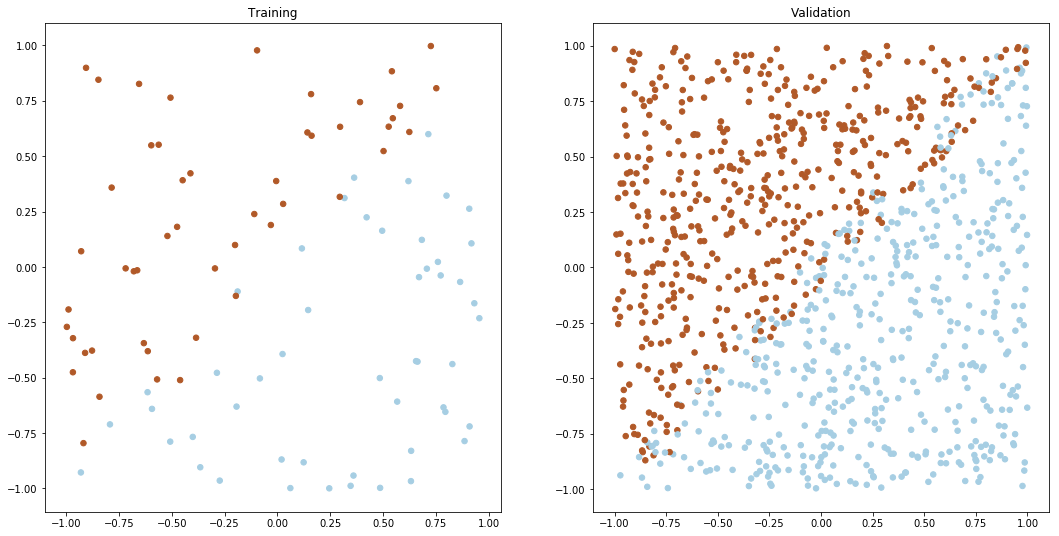

Generating circle data
Plotting circle data


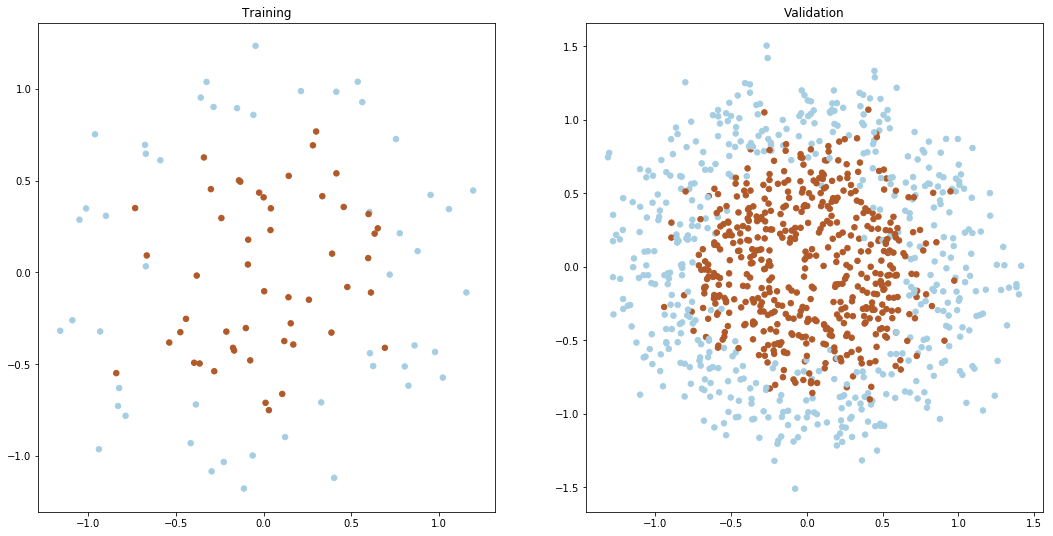

Generating moon data
Plotting moon data


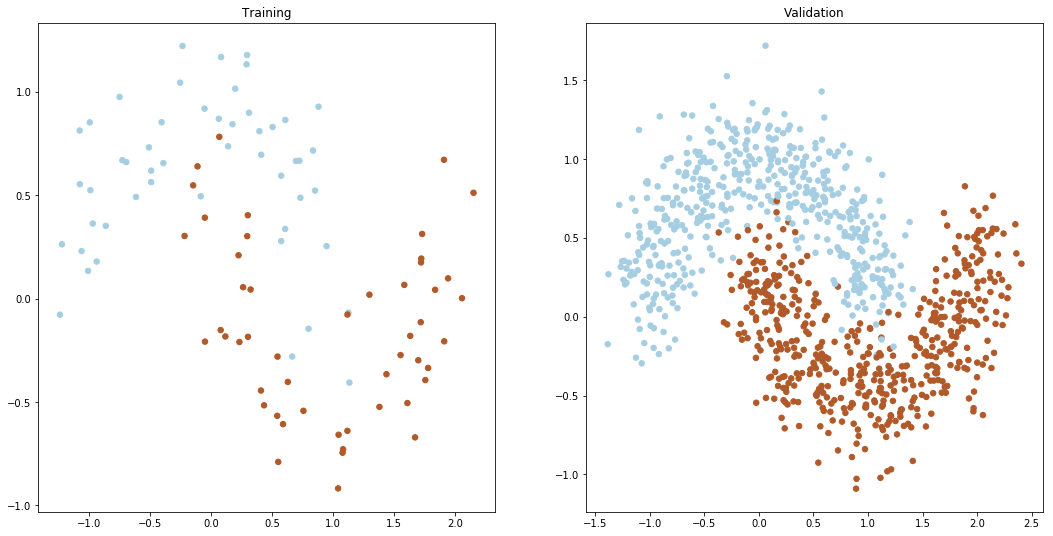

In [258]:
def generate_linearly_separable(N=20,margin=0):
    X=np.zeros((N,2))
    Y=np.zeros((N))
    a=1
    b=-1
    c=0
    n=0
    while(n<N):
        X[n,:]=2.0*np.random.ranf(2)-1.0
        if(a*X[n,0]+b*X[n,1]+c>=margin and n%2==0):
            Y[n]=0
            n+=1
        elif(a*X[n,0]+b*X[n,1]+c<-margin and n%2==1):
            Y[n]=1
            n+=1
    
    return X,Y

N_train=100
N_valid=10*N_train
margin_desired=-0.1
noise_desired_c=0.2
noise_desired_m=0.2



print("Generating linear data")
X_l,Y_l=generate_linearly_separable(N_train,margin_desired)
X_l_t,Y_l_t=generate_linearly_separable(N_valid,margin_desired)
print("Plotting linear data")
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.scatter(X_l[:, 0], X_l[:, 1], c=Y_l, s=30, cmap=plt.cm.Paired)
plt.title("Training")
plt.subplot(1,2,2)
plt.scatter(X_l_t[:, 0], X_l_t[:, 1], c=Y_l_t, s=30, cmap=plt.cm.Paired)
plt.title("Validation")
plt.savefig("linear.png")
plt.show()



print("Generating circle data")
X_c,Y_c=make_circles(n_samples=N_train, noise=noise_desired_c, factor=0.5)
X_c_t,Y_c_t=make_circles(n_samples=N_valid, noise=noise_desired_c, factor=0.5)
print("Plotting circle data")
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.scatter(X_c[:, 0], X_c[:, 1], c=Y_c, s=30, cmap=plt.cm.Paired)
plt.title("Training")
plt.subplot(1,2,2)
plt.scatter(X_c_t[:, 0], X_c_t[:, 1], c=Y_c_t, s=30, cmap=plt.cm.Paired)
plt.title("Validation")
plt.savefig("circle.png")
plt.show()



print("Generating moon data")
X_m,Y_m=make_moons(n_samples=N_train, noise=noise_desired_m)
X_m_t,Y_m_t=make_moons(n_samples=N_valid, noise=noise_desired_m)
print("Plotting moon data")
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.scatter(X_m[:, 0], X_m[:, 1], c=Y_m, s=30, cmap=plt.cm.Paired)
plt.title("Training")
plt.subplot(1,2,2)
plt.scatter(X_m_t[:, 0], X_m_t[:, 1], c=Y_m_t, s=30, cmap=plt.cm.Paired)
plt.title("Validation")
plt.savefig("moon.png")
plt.show()

In [259]:
#"""
def train_linear_SVM(X,Y,X_t,Y_t,print_results=False,plot_results=False):
    kernel_employed="linear"

    C_test=[0.001,0.01,0.1,1,10,100,1000,2000]

    S=np.zeros((len(C_test),1))

    n_cv=5

    kf = KFold(n_splits=n_cv)

    acc_best=0
    C_best=0
    gamma_best=0

    begin = time.time()

    for C in range(len(C_test)):
        c=C_test[C]
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = Y[train_index], Y[test_index]
            svc = SVC(kernel=kernel_employed, C=c)
            svc.fit(X_train, y_train)
            S[C,0]+=1.0*svc.score(X_test, y_test)/n_cv

        if(acc_best<S[C,0]):
            acc_best=S[C,0]
            C_best=C_test[C]

    svc = SVC(kernel=kernel_employed, C=C_best)
    svc.fit(X, Y)

    end=time.time()

    if(plot_results):
        plt.figure(figsize=(12,12))
        plt.scatter(X_t[:, 0], X_t[:, 1], c=Y_t, s=30, cmap=plt.cm.Paired)

        # plot the decision function
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 100)
        yy = np.linspace(ylim[0], ylim[1], 100)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = svc.decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b','r','b'], levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
        # plot support vectors
        ax.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=100,linewidth=1, facecolors='none', edgecolors='k')
        
        plt.savefig("results_SVM_linear_"+str(X.shape[0])+".png")
        plt.show()

    if(print_results):
        print("____________________________________________________________________________________________________")
        print("SVM with "+kernel_employed+" kernel trained in "+str(end-begin)+" seconds for "+str(X.shape[0])+" samples.")
        print("Accuracy on validation set: "+str(100.0*svc.score(X_t, Y_t))+"%")
        print("____________________________________________________________________________________________________")
    
    duration=end-begin
    accuracy=100.0*svc.score(X_t, Y_t)
    return duration,accuracy
#"""

In [260]:
#"""
def train_rbf_SVM(X,Y,X_t,Y_t,print_results=False,plot_results=False):
    kernel_employed="rbf"

    C_test=[0.001,0.01,0.1,1,10,100,1000,2000]
    gamma_test=[0.002,0.02,0.2,2,20,200,2000]

    S=np.zeros((len(C_test),len(gamma_test)))

    n_cv=5

    kf = KFold(n_splits=n_cv)


    acc_best=0
    C_best=0
    gamma_best=0

    begin = time.time()

    for C in range(len(C_test)):
        for G in range(len(gamma_test)):
            c=C_test[C]
            g=gamma_test[G]
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index,:], X[test_index,:]
                y_train, y_test = Y[train_index], Y[test_index]
                svc = SVC(kernel=kernel_employed, C=c, gamma=g)
                svc.fit(X_train, y_train)
                S[C,G]+=1.0*svc.score(X_test, y_test)/n_cv

            if(acc_best<S[C,G]):
                acc_best=S[C,G]
                C_best=C_test[C]
                gamma_best=gamma_test[G]

    svc = SVC(kernel=kernel_employed, C=C_best, gamma=gamma_best)
    svc.fit(X, Y)

    end=time.time()
    

    if(plot_results):
        plt.figure(figsize=(12,12))
        plt.scatter(X_t[:, 0], X_t[:, 1], c=Y_t, s=30, cmap=plt.cm.Paired)

        # plot the decision function
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 100)
        yy = np.linspace(ylim[0], ylim[1], 100)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = svc.decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b','r','b'], levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
        # plot support vectors
        ax.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=100,linewidth=1, facecolors='none', edgecolors='k')
        
        plt.savefig("results_SVM_rbf_"+str(X.shape[0])+".png")
        plt.show()

    if(print_results):
        print("____________________________________________________________________________________________________")
        print("SVM with "+kernel_employed+" kernel trained in "+str(end-begin)+" seconds for "+str(X.shape[0])+" samples.")
        print("Accuracy on validation set: "+str(100.0*svc.score(X_t, Y_t))+"%")
        print("____________________________________________________________________________________________________")
    
    duration=end-begin
    accuracy=100.0*svc.score(X_t, Y_t)
    return duration,accuracy
#"""

In [261]:
#"""
def train_poly_SVM(X,Y,X_t,Y_t,print_results=False,plot_results=False):
    kernel_employed="poly"
    degree_employed=4

    C_test=[0.001,0.01,0.1,1,10,100,1000,2000]

    S=np.zeros((len(C_test),1))

    n_cv=5

    kf = KFold(n_splits=n_cv)

    acc_best=0
    C_best=0
    gamma_best=0

    begin = time.time()

    for C in range(len(C_test)):
        c=C_test[C]
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = Y[train_index], Y[test_index]
            svc = SVC(kernel=kernel_employed, C=c, degree=degree_employed)
            svc.fit(X_train, y_train)
            S[C,0]+=1.0*svc.score(X_test, y_test)/n_cv

        if(acc_best<S[C,0]):
            acc_best=S[C,0]
            C_best=C_test[C]

    svc = SVC(kernel=kernel_employed, C=C_best, degree=degree_employed)
    svc.fit(X, Y)

    end=time.time()
    #print("SVM with "+kernel_employed+" kernel trained in "+str(end-begin)+" seconds for "+str(X.shape[0])+" samples.")

    if(plot_results):
        plt.figure(figsize=(12,12))
        plt.scatter(X_t[:, 0], X_t[:, 1], c=Y_t, s=30, cmap=plt.cm.Paired)

        # plot the decision function
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 100)
        yy = np.linspace(ylim[0], ylim[1], 100)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = svc.decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b','r','b'], levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
        # plot support vectors
        ax.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=100,linewidth=1, facecolors='none', edgecolors='k')
        
        plt.savefig("results_SVM_poly_"+str(X.shape[0])+".png")
        plt.show()

    if(print_results):
        print("____________________________________________________________________________________________________")
        print("SVM with "+kernel_employed+" kernel trained in "+str(end-begin)+" seconds for "+str(X.shape[0])+" samples.")
        print("Accuracy on validation set: "+str(100.0*svc.score(X_t, Y_t))+"%")
        print("____________________________________________________________________________________________________")
    
    duration=end-begin
    accuracy=100.0*svc.score(X_t, Y_t)
    return duration,accuracy
#"""

In [262]:
#"""
def train_DL_model(X,Y,X_t,Y_t,print_results=False,plot_results=False,nf=16,epochs=1,model_verbose=0):
    
    I=Input(shape=(X.shape[1],),name="Input")
    D1=Dense(nf,activation="relu")(I)
    D2=Dense(nf,activation="relu")(D1)
    D3=Dense(nf,activation="relu")(D2)
    D4=Dense(nf,activation="relu")(D3)
    O=Dense(1,activation="sigmoid")(D4)

    model=Sequential()
    model=Model(inputs=[I], outputs=[O])

    # initiate RMSprop optimizer
    opt=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    opt=keras.optimizers.Adam()

    losses=["binary_crossentropy"]
    employed_metrics=["accuracy"]
    employed_weights=[1.0]
    model.compile(optimizer=opt, loss=losses, metrics=employed_metrics, loss_weights=employed_weights)

    batch_size=100
    
    begin = time.time()

    """
    n_cv=5
    kf = KFold(n_splits=n_cv)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = Y[train_index], Y[test_index]
    #"""
    model.fit([X],[Y],batch_size=batch_size,epochs=epochs,verbose=model_verbose)

    end=time.time()

    Y_p=model.predict(X_t, batch_size=batch_size,verbose=model_verbose)

    Y_p_f=np.round(Y_p)
    
    Y_p_t=model.predict(X, batch_size=batch_size,verbose=model_verbose)

    Y_p_f_t=np.round(Y_p_t)
    
    if(plot_results):
        plt.figure(figsize=(9,9))
        plt.subplot(2,2,1)
        plt.title("Training data")
        plt.scatter(X[:, 0], X[:, 1], c=Y, s=30, cmap=plt.cm.Paired)

        plt.subplot(2,2,2)
        plt.title("Training results")
        plt.scatter(X[:, 0], X[:, 1], c=Y_p_f_t[:,0], s=30, cmap=plt.cm.Paired)
        
        plt.subplot(2,2,3)
        plt.title("Validation data")
        plt.scatter(X_t[:, 0], X_t[:, 1], c=Y_t, s=30, cmap=plt.cm.Paired)

        plt.subplot(2,2,4)
        plt.title("Validation results")
        plt.scatter(X_t[:, 0], X_t[:, 1], c=Y_p_f[:,0], s=30, cmap=plt.cm.Paired)
        
        plt.savefig("results_DL_"+str(X.shape[0])+".png")
        
        plt.show()

    loss_and_metrics_v=model.evaluate([X_t], [Y_t], batch_size=batch_size,verbose=model_verbose)
    loss_and_metrics_t=model.evaluate([X], [Y], batch_size=batch_size,verbose=model_verbose)
    
    if(print_results):
        print("____________________________________________________________________________________________________")
        print("Model trained in "+str(end-begin)+" seconds for "+str(X.shape[0])+" samples.")
        print("Accuracy on training set: "+str(100.0*loss_and_metrics_t[1])+"%")
        print("Accuracy on validation set: "+str(100.0*loss_and_metrics_v[1])+"%")
        print("____________________________________________________________________________________________________")
    
    duration=end-begin
    accuracy=100.0*loss_and_metrics_v[1]
    return duration,accuracy
#"""

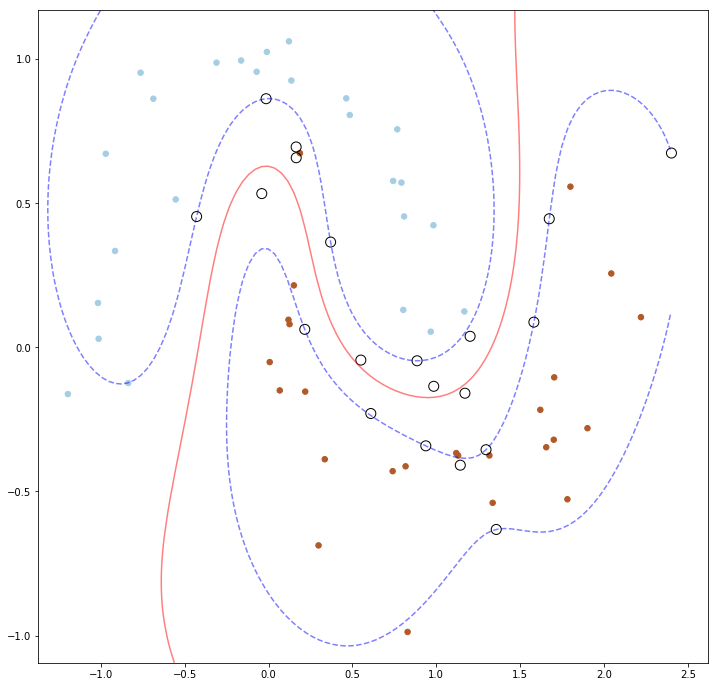

____________________________________________________________________________________________________
SVM with rbf kernel trained in 0.14276695251464844 seconds for 100 samples.
Accuracy on validation set: 98.0%
____________________________________________________________________________________________________
Epoch 1/1
100/100 [==============================] - 0s 230us/step


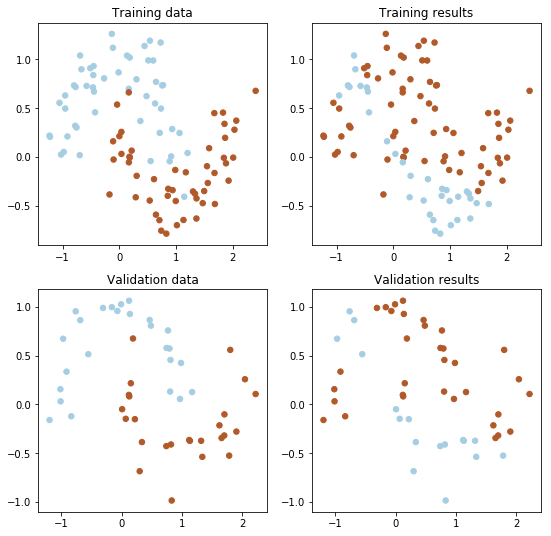

100/100 [==============================] - 0s 236us/step
____________________________________________________________________________________________________
Model trained in 76.64351177215576 seconds for 100 samples.
Accuracy on training set: 37.00000047683716%
Accuracy on validation set: 31.999999284744263%
____________________________________________________________________________________________________


In [265]:
N_train=100
N_valid=50

margin_desired=-0.05
noise_desired_c=0.2
noise_desired_m=0.2

#X,Y=generate_linearly_separable(N_train,margin_desired)
#X_t,Y_t=generate_linearly_separable(N_valid,margin_desired)

#X,Y=make_circles(n_samples=N_train, noise=noise_desired_c, factor=0.5)
#X_t,Y_t=make_circles(n_samples=N_valid, noise=noise_desired_c, factor=0.5)

X,Y=make_moons(n_samples=N_train, noise=noise_desired_m)
X_t,Y_t=make_moons(n_samples=N_valid, noise=noise_desired_m)

"""
print("Plotting data")
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.scatter(X[:, 0], X[:, 1], c=Y, s=30, cmap=plt.cm.Paired)
plt.title("Training")
plt.subplot(1,2,2)
plt.scatter(X_t[:, 0], X_t[:, 1], c=Y_t, s=30, cmap=plt.cm.Paired)
plt.title("Validation")
plt.show()
#"""


#metric_SVM=train_linear_SVM(X,Y,X_t,Y_t,True,True)
metric_SVM=train_rbf_SVM(X,Y,X_t,Y_t,True,True)
#metric_SVM=train_poly_SVM(X,Y,X_t,Y_t,True,True)
metric_DL=train_DL_model(X,Y,X_t,Y_t,print_results=True,plot_results=True,nf=16,epochs=1,model_verbose=1)

Iteration 1/2
	 Training on 10 samples.
	 Training on 20 samples.
	 Training on 30 samples.
	 Training on 40 samples.
	 Training on 50 samples.
Iteration 2/2
	 Training on 10 samples.
	 Training on 20 samples.
	 Training on 30 samples.
	 Training on 40 samples.
	 Training on 50 samples.


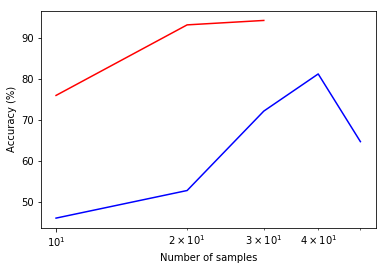

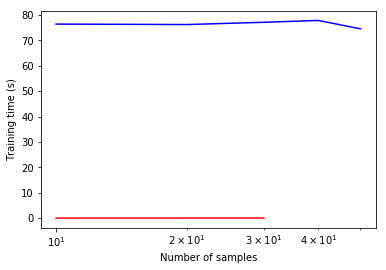

In [266]:
N_samples=[10,50,100,200,500,1000,2000,5000,10000,20000,50000,100000]

N_it=50
N_id_sample_SVM=9

N_samples_SVM=np.zeros((N_id_sample_SVM,N_it))
time_SVM=np.zeros((N_id_sample_SVM,N_it))
accuracy_SVM=np.zeros((N_id_sample_SVM,N_it))

N_samples_DL=np.zeros((len(N_samples),N_it))
time_DL=np.zeros((len(N_samples),N_it))
accuracy_DL=np.zeros((len(N_samples),N_it))

for n in range(N_it):
    print("Iteration "+str(n+1)+"/"+str(N_it))
    for k in range(len(N_samples)):
        N_train = N_samples[k]
        print("\t Training on "+str(N_train)+" samples.")
        N_valid=10*N_train
        margin_desired=-0.02

        #print("Generating data")
        X,Y=generate_linearly_separable(N_train,margin_desired)
        X_t,Y_t=generate_linearly_separable(N_valid,margin_desired)

        if(k<N_id_sample_SVM):
            metric_SVM=train_linear_SVM(X,Y,X_t,Y_t,False,False)
            N_samples_SVM[k,n]=(N_train)
            time_SVM[k,n]=(metric_SVM[0])
            accuracy_SVM[k,n]=(metric_SVM[1])

        metric_DL=train_DL_model(X,Y,X_t,Y_t,print_results=False,plot_results=False,nf=16,epochs=10,model_verbose=0)
        N_samples_DL[k,n]=(N_train)
        time_DL[k,n]=(metric_DL[0])
        accuracy_DL[k,n]=(metric_DL[1])


plt.semilogx(1.0*np.sum(N_samples_SVM,axis=1)/N_it,1.0*np.sum(accuracy_SVM,axis=1)/N_it,'r')
plt.semilogx(1.0*np.sum(N_samples_DL,axis=1)/N_it,1.0*np.sum(accuracy_DL,axis=1)/N_it,'b')
plt.xlabel("Number of samples")
plt.ylabel("Accuracy (%)")
plt.savefig("accuracy_linear.png")
plt.show()
    
plt.semilogx(1.0*np.sum(N_samples_SVM,axis=1)/N_it,1.0*np.sum(time_SVM,axis=1)/N_it,'r')
plt.semilogx(1.0*np.sum(N_samples_DL,axis=1)/N_it,1.0*np.sum(time_DL,axis=1)/N_it,'b')
plt.xlabel("Number of samples")
plt.ylabel("Training time (s)")
plt.savefig("time_linear.png")
plt.show()

In [248]:
N_samples=[10,50,100,200,500,1000,2000,5000,10000,20000,50000,100000]

N_it=50
N_id_sample_SVM=8

N_samples_SVM=np.zeros((N_id_sample_SVM,N_it))
time_SVM=np.zeros((N_id_sample_SVM,N_it))
accuracy_SVM=np.zeros((N_id_sample_SVM,N_it))

N_samples_DL=np.zeros((len(N_samples),N_it))
time_DL=np.zeros((len(N_samples),N_it))
accuracy_DL=np.zeros((len(N_samples),N_it))

for n in range(N_it):

    for k in range(len(N_samples)):
        N_train = N_samples[k]
        N_valid=10*N_train
        margin_desired=-0.02

        #print("Generating data")
        X,Y=make_moons(n_samples=N_train, noise=noise_desired_m)
        X_t,Y_t=make_moons(n_samples=N_valid, noise=noise_desired_m)

        if(k<N_id_sample_SVM):
            metric_SVM=train_rbf_SVM(X,Y,X_t,Y_t,False,False)
            N_samples_SVM[k,n]=(N_train)
            time_SVM[k,n]=(metric_SVM[0])
            accuracy_SVM[k,n]=(metric_SVM[1])

        metric_DL=train_DL_model(X,Y,X_t,Y_t,print_results=False,plot_results=False,nf=16,epochs=10,model_verbose=0)
        N_samples_DL[k,n]=(N_train)
        time_DL[k,n]=(metric_DL[0])
        accuracy_DL[k,n]=(metric_DL[1])


plt.semilogx(1.0*np.sum(N_samples_SVM,axis=1)/N_it,1.0*np.sum(accuracy_SVM,axis=1)/N_it,'r')
plt.semilogx(1.0*np.sum(N_samples_DL,axis=1)/N_it,1.0*np.sum(accuracy_DL,axis=1)/N_it,'b')
plt.xlabel("Number of samples")
plt.ylabel("Accuracy (%)")
plt.savefig("accuracy_moon.png")
plt.show()
    
plt.semilogx(1.0*np.sum(N_samples_SVM,axis=1)/N_it,1.0*np.sum(time_SVM,axis=1)/N_it,'r')
plt.semilogx(1.0*np.sum(N_samples_DL,axis=1)/N_it,1.0*np.sum(time_DL,axis=1)/N_it,'b')
plt.xlabel("Number of samples")
plt.ylabel("Training time (s)")
plt.savefig("time_moon.png")
plt.show()

	 Training on 10 samples.
	 Training on 50 samples.
	 Training on 100 samples.
	 Training on 200 samples.
	 Training on 500 samples.
	 Training on 1000 samples.
	 Training on 2000 samples.
	 Training on 5000 samples.
	 Training on 10000 samples.
	 Training on 20000 samples.
	 Training on 50000 samples.
	 Training on 100000 samples.
	 Training on 10 samples.
	 Training on 50 samples.
	 Training on 100 samples.
	 Training on 200 samples.
	 Training on 500 samples.
	 Training on 1000 samples.
	 Training on 2000 samples.
	 Training on 5000 samples.
	 Training on 10000 samples.
	 Training on 20000 samples.
	 Training on 50000 samples.
	 Training on 100000 samples.
	 Training on 10 samples.
	 Training on 50 samples.
	 Training on 100 samples.
	 Training on 200 samples.
	 Training on 500 samples.
	 Training on 1000 samples.
	 Training on 2000 samples.
	 Training on 5000 samples.
	 Training on 10000 samples.
	 Training on 20000 samples.
	 Training on 50000 samples.
	 Training on 100000 samples

KeyboardInterrupt: 